### Урок 6. Градиентный бустинг

### Домашние задания

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

1. **Задание**.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

Запишем модель градиетного бустинга из методички

In [156]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [157]:
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt

In [158]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [159]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.

$$a_{N}(x) = \sum^{N}_{n=1}\eta\gamma_{n}b_{n}(x).$$

In [160]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [161]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [162]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [163]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [164]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    
    train_err = round(mean_squared_error(y_train, train_prediction))

    print(f'Ошибка алгоритма из {n_tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {train_err}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    
    test_err = round(mean_squared_error(y_test, test_prediction))

    print(f'Ошибка алгоритма из {n_tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {test_err}')
    return train_err, test_err

In [165]:
# функция для построения графика
def get_error_plot(n_trees, train_err, test_err, eta, n_tree):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.title(f'Dependence of MSE from number of trees with eta = {eta}, number of trees = {n_tree}')
    plt.legend(loc='upper right')
    plt.show()

In [166]:
#функция, чтобы построить все ошибка на одном графике при каждой скорости обучения    
def get_all_errors_plot_for_eta(n_tree, train_mse, test_mse, etas):
    plt.figure(figsize= (16, 8))
    plt.xlim(0, n_tree)
    plt.ylim(-1000, len(train_mse) + 1000)

    ax1 = plt.subplot(221)  
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    ax1.set_title(f'Train, number of trees = {n_tree}')

    ax2 = plt.subplot(222)
    ax2.set_title(f'Test, number of trees = {n_tree}')
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')

    for i in range(len(etas)):
        ax1.plot(list(range(1, n_tree+1)), train_mse[i], label=f'eta = {etas[i]}')
        ax2.plot(list(range(1, n_tree+1)), test_mse[i], label=f'eta = {etas[i]}')

    plt.legend(loc='upper right')
    plt.show()

Теперь будем выполнять задание:

    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

Построим зависимости ошибки от количества деревьев при разных значениях шага градиента

In [167]:
# количество деревьев 
n_trees = [10, 15, 20, 25, 30, 40]

# шаг градиента
etas = [0.5, 0.25, 0.05]

In [168]:
# максимальная глубина деревьев
max_depth = 3

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1095
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 4845


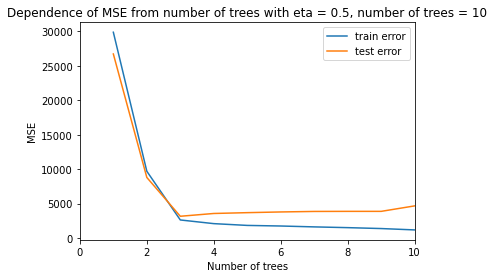

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.25 на тренировочной выборке: 1521
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.25 на тестовой выборке: 3282


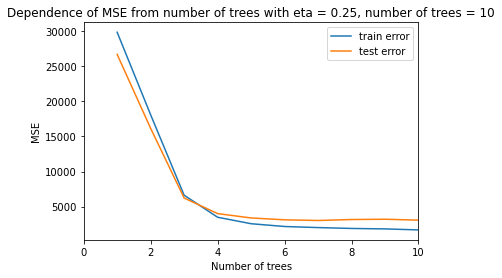

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 6281
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 5836


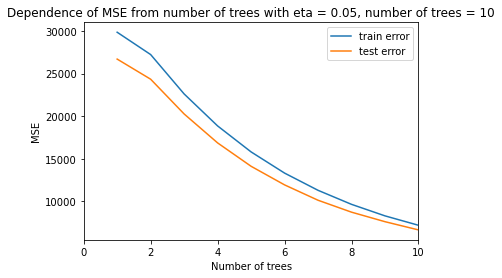

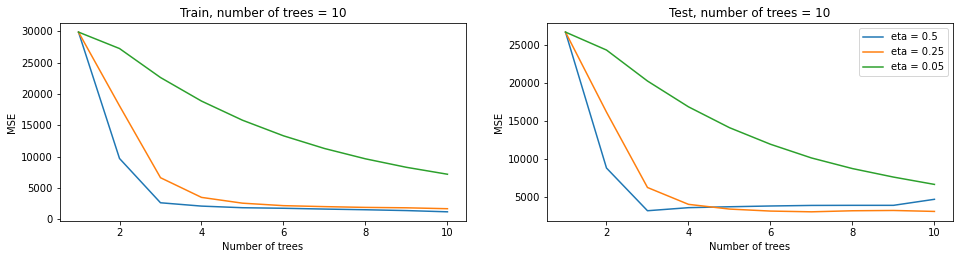

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 839
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 4742


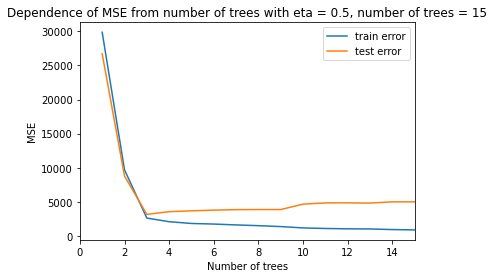

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.25 на тренировочной выборке: 1249
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.25 на тестовой выборке: 3583


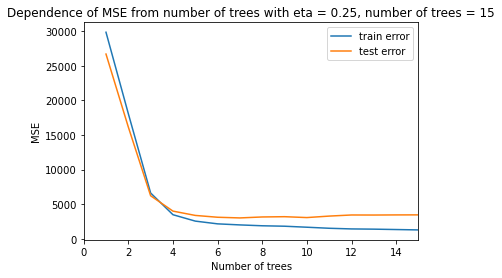

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 3641
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3782


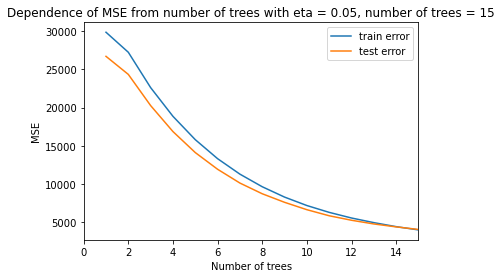

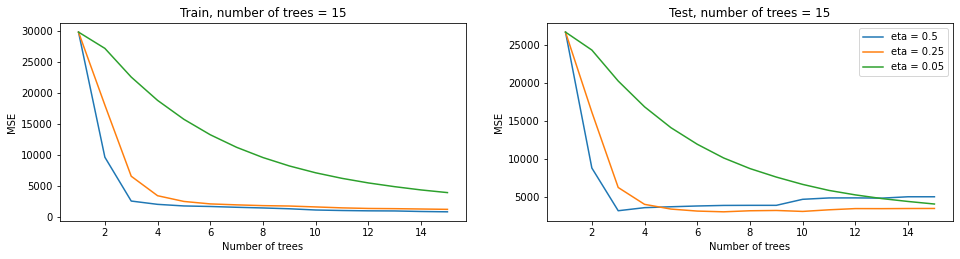

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 624
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5142


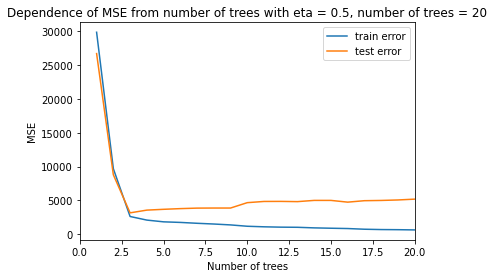

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.25 на тренировочной выборке: 980
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.25 на тестовой выборке: 3669


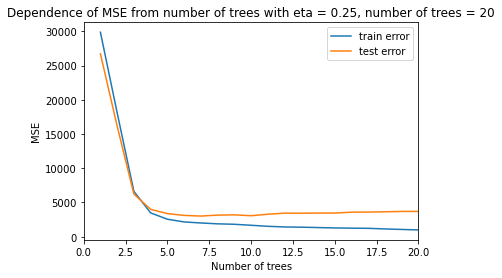

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2556
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3122


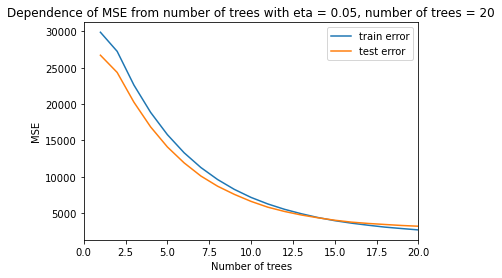

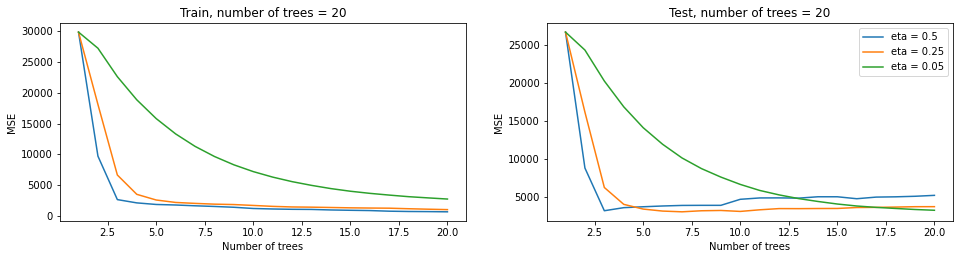

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 413
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5289


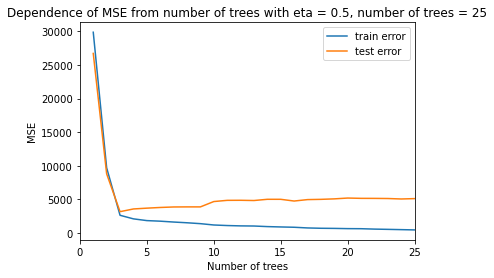

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.25 на тренировочной выборке: 725
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.25 на тестовой выборке: 3796


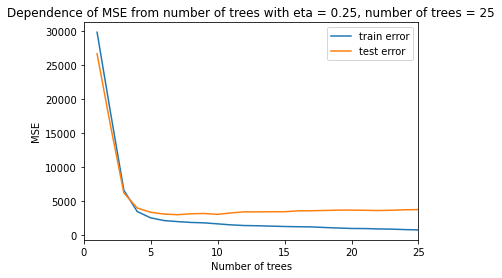

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993


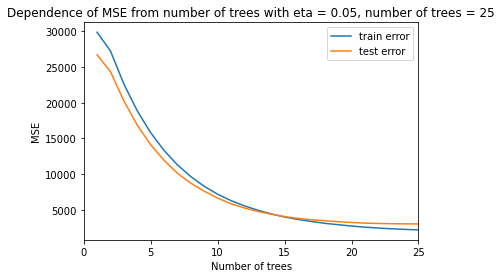

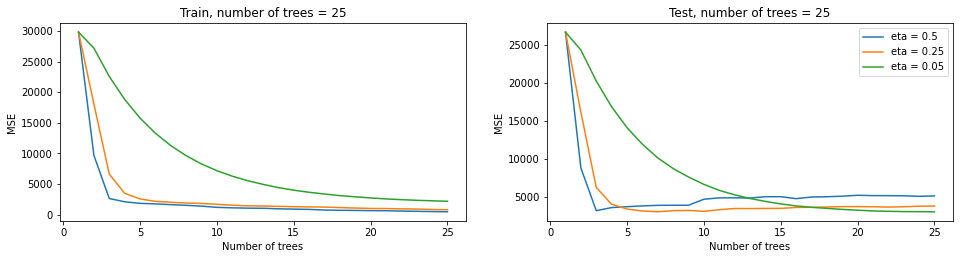

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 288
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5388


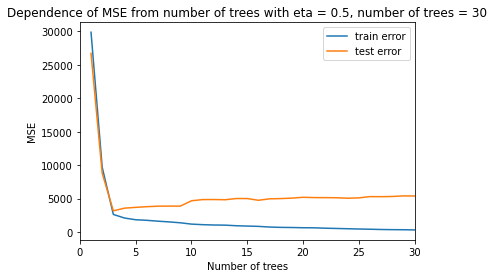

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.25 на тренировочной выборке: 555
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.25 на тестовой выборке: 3924


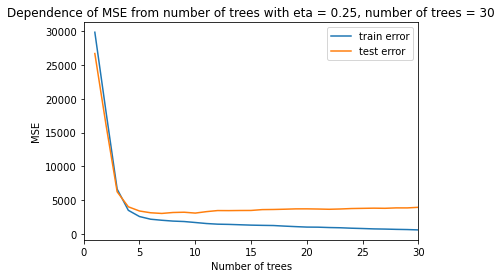

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1855
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2977


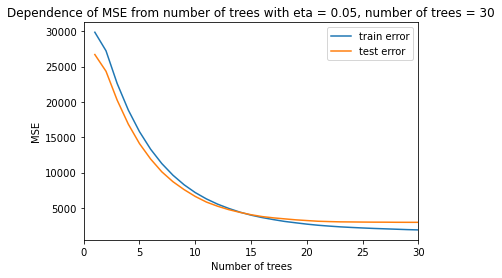

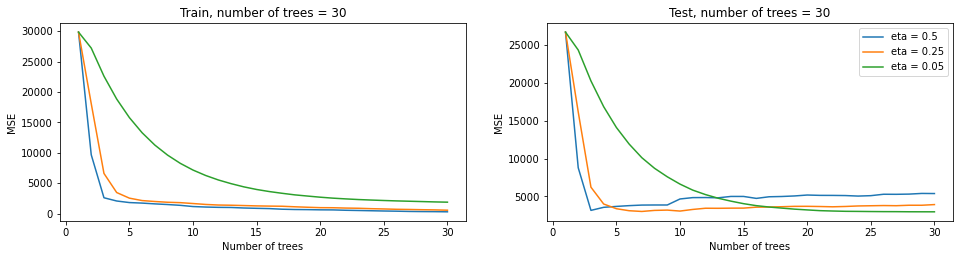

Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 133
Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5507


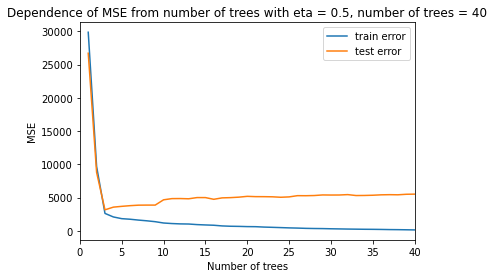

Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.25 на тренировочной выборке: 364
Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.25 на тестовой выборке: 3987


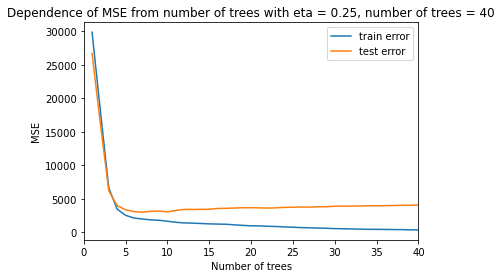

Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1579
Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2997


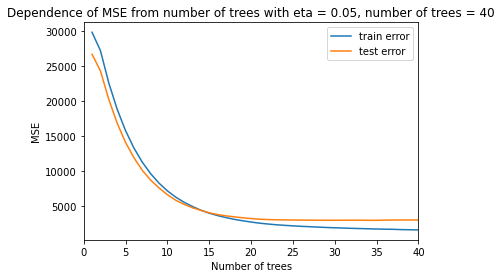

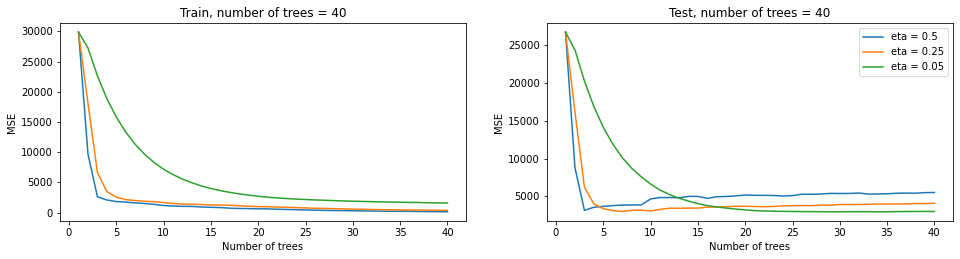

Лучшие параметры по MSE на тесте: 
Количество деревьев = 30
Шаг градиента = 0.05
MSE на трейне = 1855
MSE на тесте = 2977


In [169]:
# в цикле проверим все параметры
test_err_best = np.inf

for n_tree in n_trees:  
    # будем фиксировать ошибки алгоритма
    train_mse = []
    test_mse = []
    
    for eta in etas:     
        # для простоты примем коэффициенты равными 1
        coefs = [1] * n_tree
        
        #обучаем модель
        trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        
        #оцениваем алгоритм
        train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth)
        
        if test_err < test_err_best:
            best_n_tree, best_eta, train_err_best, test_err_best =  n_tree, eta, train_err, test_err
        
        # добавляет ошибки в списки
        train_mse.append(train_errors)
        test_mse.append(test_errors)
        
        # построим графики ошибок на каждой итерации
        get_error_plot(n_tree, train_errors, test_errors, eta, n_tree)
        
    get_all_errors_plot_for_eta(n_tree=n_tree, train_mse=train_mse, test_mse= test_mse, etas=etas)

print('Лучшие параметры по MSE на тесте: ')
print(f'Количество деревьев = {best_n_tree}')
print(f'Шаг градиента = {best_eta}')
print(f'MSE на трейне = {train_err_best}')
print(f'MSE на тесте = {test_err_best}')
        

**Выводы**

**Лучшие параметры получились следующие:**

Количество деревьев = 30

Шаг градиента = 0.05

MSE на трейне = 1855

MSE на тесте = 2977

График:

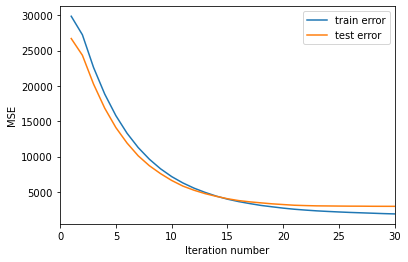

Ошибка на тесте пока не растет, значит переобучения пока нет. 

**Параметры при которых нет переобучения или оно минимально и при этом неплохой результат MSE**:

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 2617

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 3190

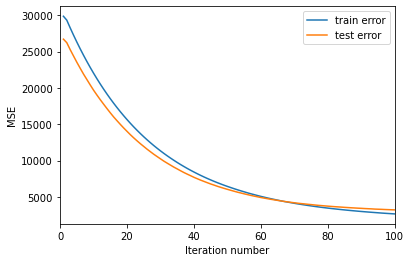

Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1579

Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2997

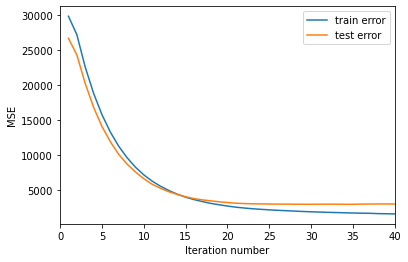

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1406

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3048

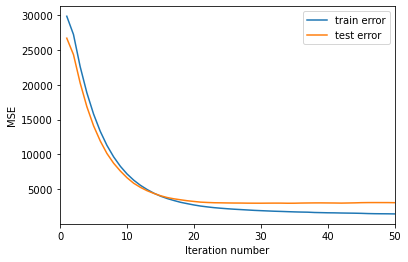

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993

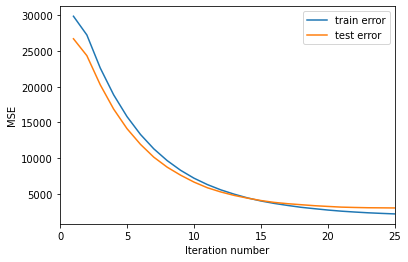

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2556

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3122

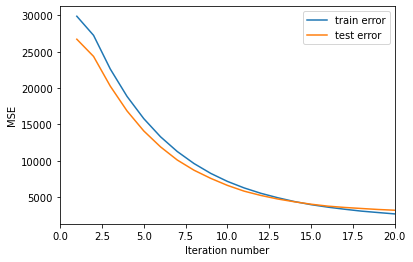


**Зависимость параметров:**

Чем больше шаг обучения - тем быстрее достигается минимальная ошибка, но больше возможности получить переобучение модели.

Чем больше деревьев - тем больше вероятность дойти до минимальной ошибки. При сравнительно высокой скрости обучения, модель может переобучиться. 

**Теперь построим зависимости для разной глубины деревьев**

In [170]:
# количество деревьев 
n_trees = [10, 15, 20, 25, 30, 40]

# глубина деревьев
max_depth = [2, 3, 4, 5]

# шаг градиента
eta = 0.05

In [171]:
# функция для построения графика
def get_error_plot_depth(n_trees, train_err, test_err, eta, depth):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.title(f'Dependence of MSE from number of trees with max_depth = {depth}, number of trees = {n_tree}, eta = {eta}')
    plt.legend(loc='upper right')
    plt.show()

In [172]:
#функция, чтобы построить все ошибка на одном графике при каждой скорости обучения    
def get_all_errors_plot_for_depth(n_tree, train_mse, test_mse, max_depth):
    plt.figure(figsize= (16, 8))
    plt.xlim(0, n_tree)
    plt.ylim(-1000, len(train_mse) + 1000)

    ax1 = plt.subplot(221)  
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    ax1.set_title(f'Train, number of trees = {n_tree}')

    ax2 = plt.subplot(222)
    ax2.set_title(f'Test, number of trees = {n_tree}')
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')

    for i in range(len(max_depth)):
        ax1.plot(list(range(1, n_tree+1)), train_mse[i], label=f'max_depth = {max_depth[i]}')
        ax2.plot(list(range(1, n_tree+1)), test_mse[i], label=f'max_depth = {max_depth[i]}')

    plt.legend(loc='upper right')
    plt.show()

Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 6711
Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 5955


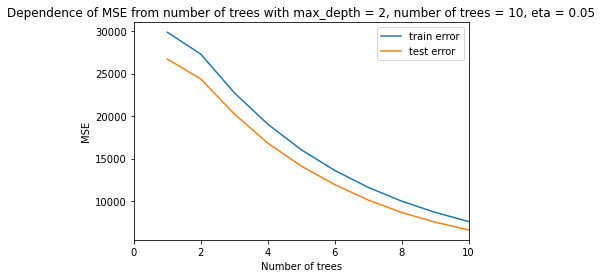

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 6281
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 5836


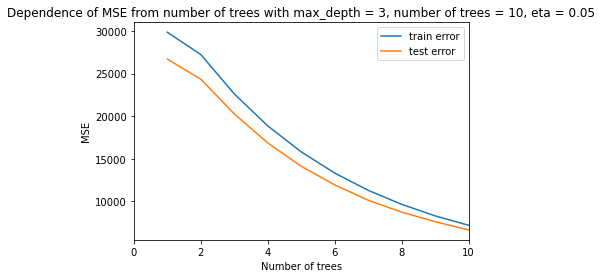

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 5797
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 6077


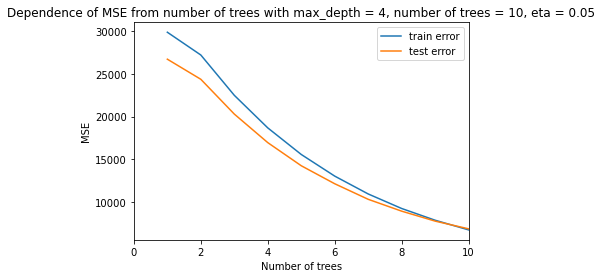

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 5332
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 6121


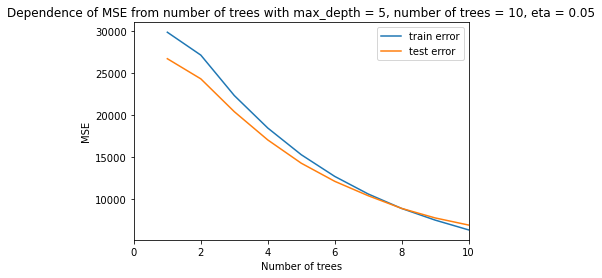

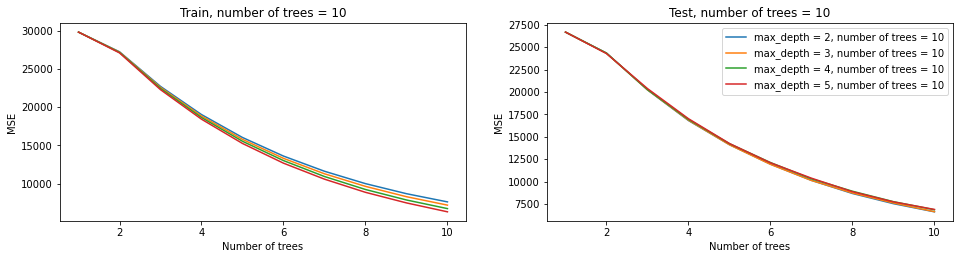

Ошибка алгоритма из 15 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 4148
Ошибка алгоритма из 15 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 3881


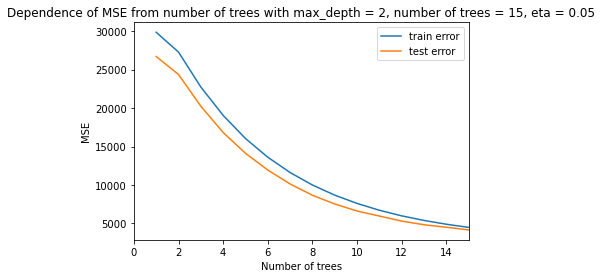

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 3641
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3782


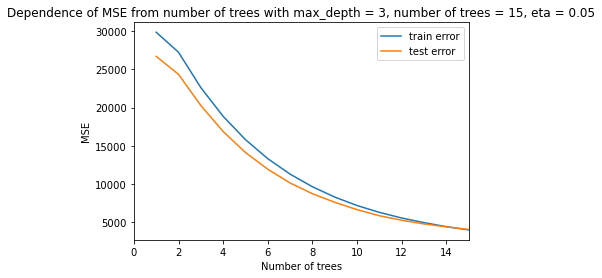

Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 3066
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 4010


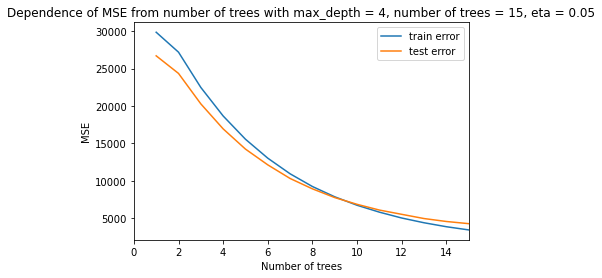

Ошибка алгоритма из 15 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 2552
Ошибка алгоритма из 15 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 4204


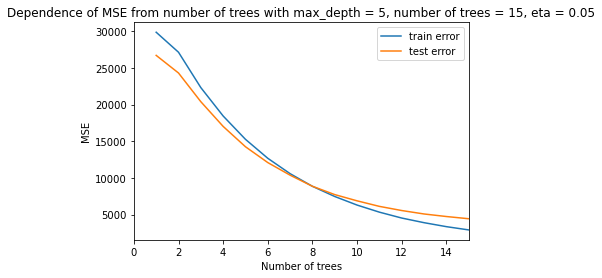

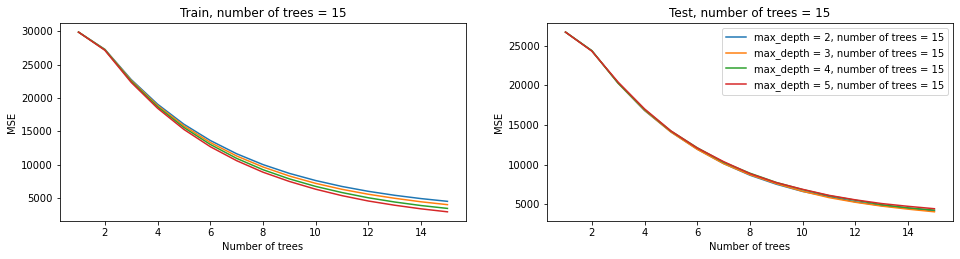

Ошибка алгоритма из 20 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 3138
Ошибка алгоритма из 20 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 3196


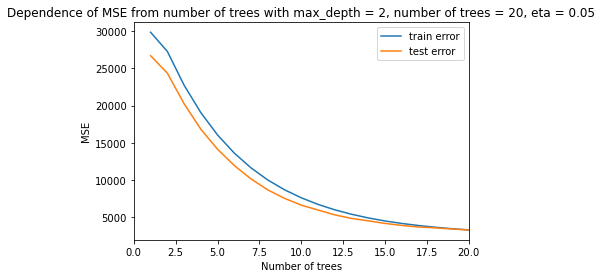

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2556
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3122


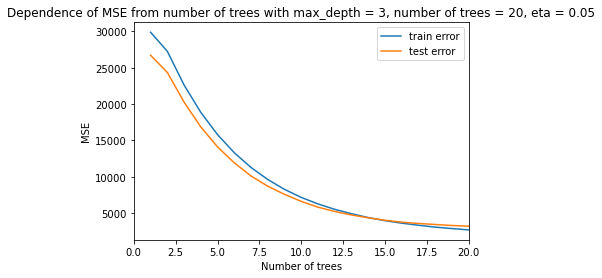

Ошибка алгоритма из 20 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 1967
Ошибка алгоритма из 20 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 3361


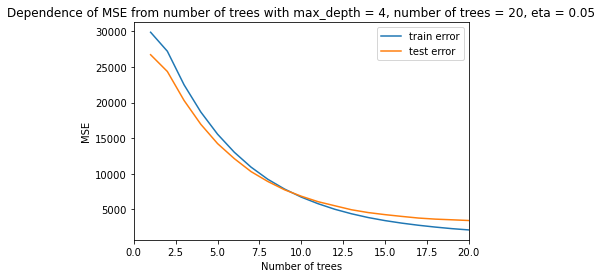

Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 1389
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3674


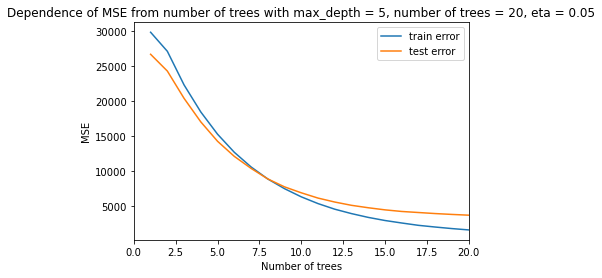

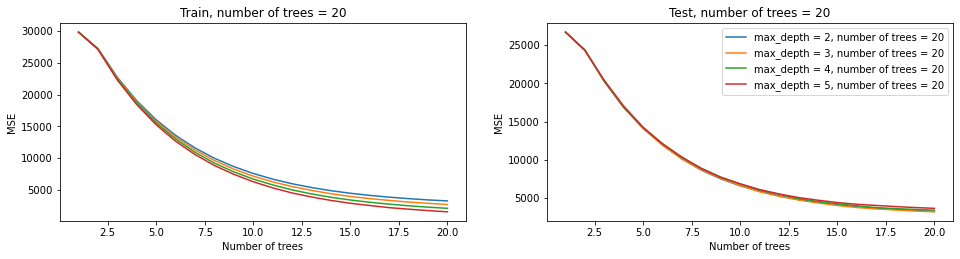

Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 2692
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 2992


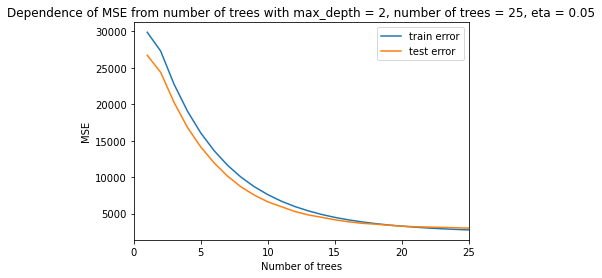

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993


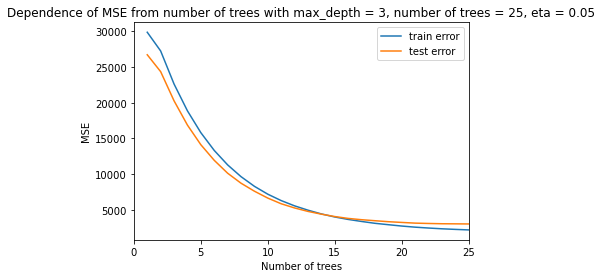

Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 1456
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 3147


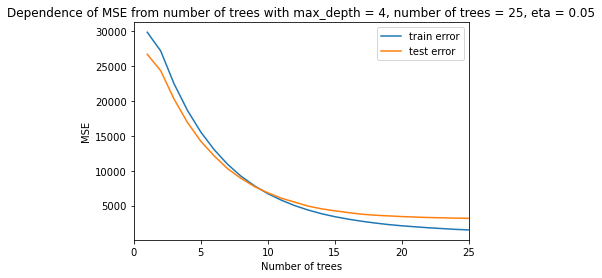

Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 889
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3614


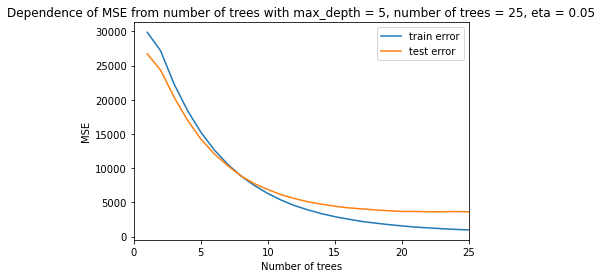

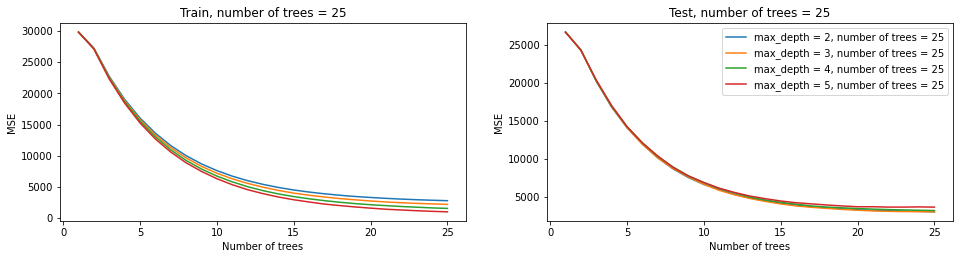

Ошибка алгоритма из 30 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 2471
Ошибка алгоритма из 30 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 2928


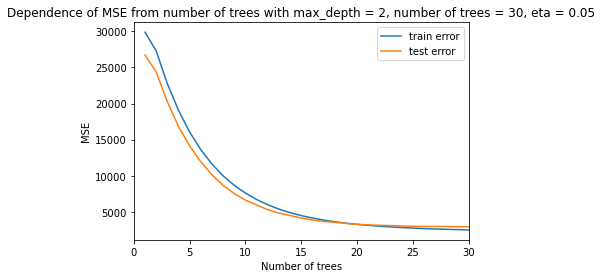

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1855
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2977


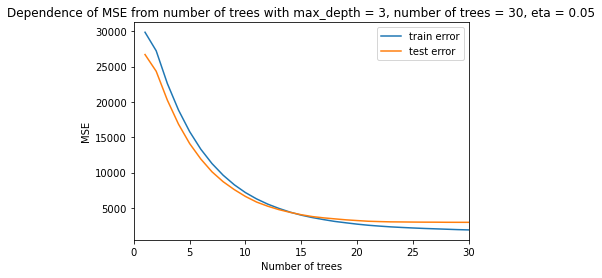

Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 1217
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 3117


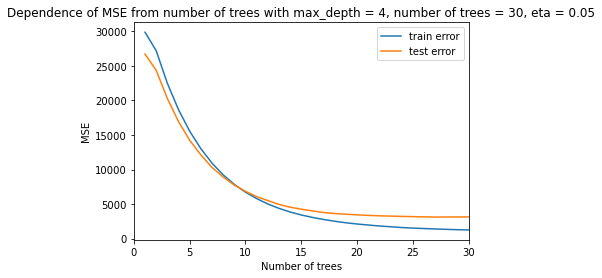

Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 655
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3649


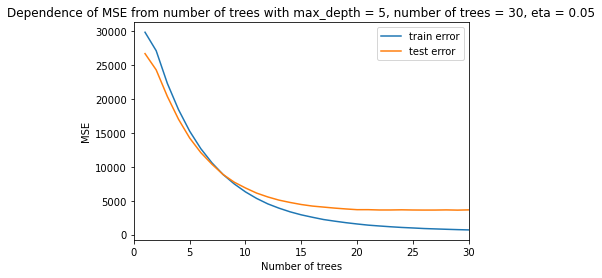

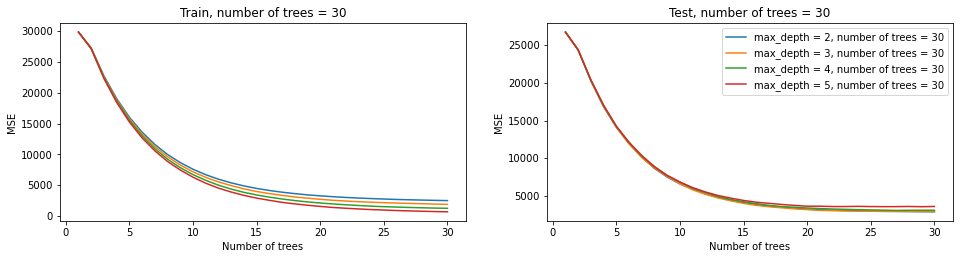

Ошибка алгоритма из 40 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 2209
Ошибка алгоритма из 40 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 2907


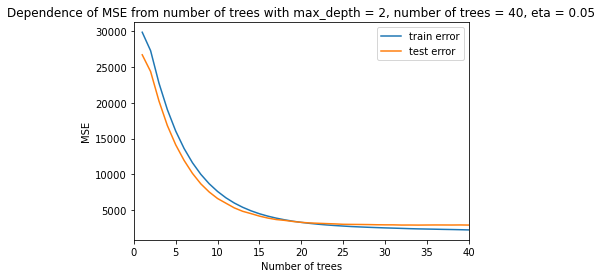

Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1579
Ошибка алгоритма из 40 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2997


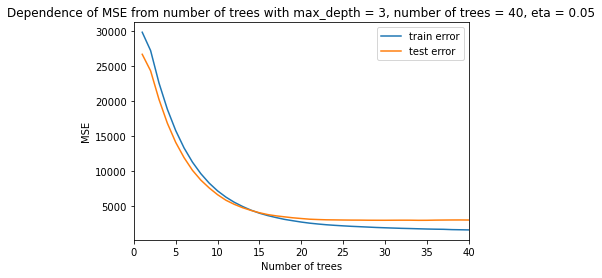

Ошибка алгоритма из 40 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 991
Ошибка алгоритма из 40 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 3039


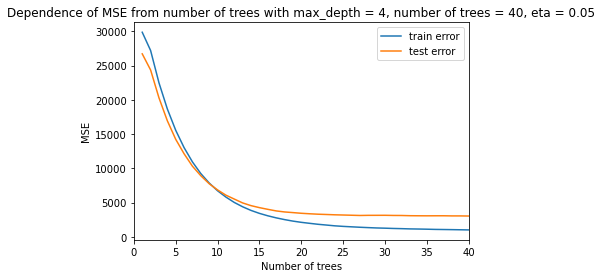

Ошибка алгоритма из 40 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 439
Ошибка алгоритма из 40 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3642


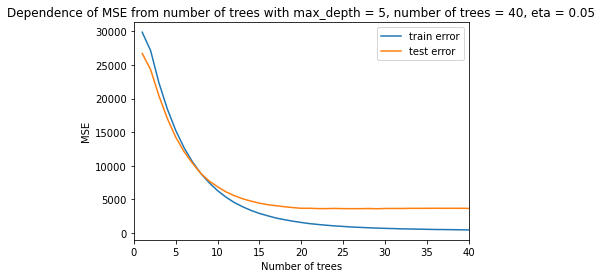

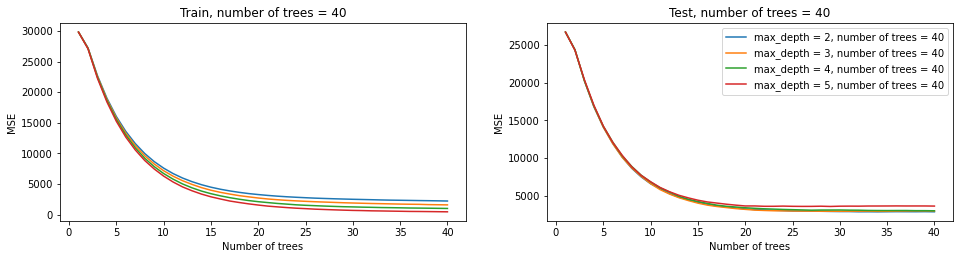

Лучшие параметры по MSE на тесте: 
Количество деревьев = 40
Глубина дерева = 2
MSE на трейне = 2209
MSE на тесте = 2907


In [173]:
# в цикле проверим все параметры

test_err_best = np.inf

for n_tree in n_trees:
    # будем фиксировать ошибки алгоритма
    train_mse = []
    test_mse = []
    
    for depth in max_depth:     
        # для простоты примем коэффициенты равными 1
        coefs = [1] * n_tree
        
        #обучаем модель
        trees, train_errors, test_errors = gb_fit(n_tree, depth, X_train, X_test, y_train, y_test, coefs, eta)
        
        #оцениваем алгоритм
        train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, depth)
        
        if test_err < test_err_best:
            best_n_tree, best_depth, train_err_best, test_err_best =  n_tree, depth, train_err, test_err
        
        # добавляет ошибки в списки
        train_mse.append(train_errors)
        test_mse.append(test_errors)
        
        # построим графики ошибок на каждой итерации
        get_error_plot_depth(n_tree, train_errors, test_errors, eta, depth)
        
    get_all_errors_plot_for_depth(n_tree=n_tree, train_mse=train_mse, test_mse= test_mse, max_depth=max_depth)

print('Лучшие параметры по MSE на тесте: ')
print(f'Количество деревьев = {best_n_tree}')
print(f'Глубина дерева = {best_depth}')
print(f'MSE на трейне = {train_err_best}')
print(f'MSE на тесте = {test_err_best}')

**Выводы**

Лучшие параметры по MSE на тесте: 
Количество деревьев = 40
Глубина дерева = 2
MSE на трейне = 2209
MSE на тесте = 2907

Выводы, касательно глубины деревьев аналогичные, бОльшая глубина деревьев помогает лучше обучаться, с другой стороны может спо